<a href="https://colab.research.google.com/github/bforsbe/SK2534/blob/main/Lattice_Folding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lab 5: 2D Lattice Protein Folding (Monte Carlo) — Guided Version with Answers

This guided notebook adapts the classic hydrophobic–polar (HP) **lattice protein** exercise into a fully self-contained lab.  
You will:
- Build and run a Monte Carlo (MC) folding simulation on a 2D square lattice.
- Use a simple **contact score** as a proxy for enthalpic stabilization.
- Observe search dynamics with and without a Metropolis acceptance criterion.
- Compare score trajectories and animations.
- Complete conceptual questions and check your work against detailed answers.

All code needed is provided below. You only change a few parameters (e.g., the sequence string or number of steps).



## Background and Model Assumptions

1. **HP lattice model.** Each residue is either hydrophobic (H) or polar (W). The chain lives on a 2D square lattice with unit bond length (|Δx| + |Δy| = 1 between neighbors).
2. **Self-avoiding walk (SAW).** The chain may not overlap itself; each lattice site can host at most one residue.
3. **Energy proxy (score).** We use an integer **score** in place of a physically dimensioned energy. The score rewards **non-consecutive H–H contacts** that are adjacent on the lattice (Manhattan distance = 1). Contacts between residues adjacent along the backbone do not contribute.
4. **Monte Carlo moves.** We apply local moves (end moves, corner flips) via a simple perturbation scheme that preserves bond length and avoids self-intersections.
5. **Metropolis acceptance.** By default we use a Metropolis-like rule with an implicit temperature scaling: uphill moves are probabilistically accepted with P ≈ exp(−|Δscore|). Turning Metropolis off is equivalent to exploring at very high “temperature.”
6. **Goals.** This model is too crude to predict real structures, but it is excellent for learning how sequence patterns, contact preferences, and search dynamics interact to create compact, stabilized conformations on a rugged energy landscape.



## Part 0 — Imports and Random Seed

Nothing to modify here.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML

# Deterministic runs unless you change this seed:
rng = np.random.default_rng(42)



## Part 1 — Define the Sequence and Index Sets

Set your sequence here. Only characters 'H' and 'W' are allowed. You can revisit this later for the design tasks.


In [2]:

# Student parameter: sequence string with 'H' and 'W' only.
sequence = "HWHWHHWHW"
NrResidues = len(sequence)

# Hydrophobic and polar index lists (used in scoring and visualization)
indexHPL = [i for i,b in enumerate(sequence) if b == "W"]
indexHPH = [i for i,b in enumerate(sequence) if b == "H"]

# Colors for visualization (H=blue, W=green)
colors = ['blue' if s == 'H' else 'green' for s in sequence]

print(f"Sequence length: {NrResidues}")
print(f"H indices: {indexHPH}")
print(f"W indices: {indexHPL}")


Sequence length: 9
H indices: [0, 2, 4, 5, 7]
W indices: [1, 3, 6, 8]



## Part 2 — Chain Initialization and Local Moves

We represent the chain as an array of 2D integer coordinates (x, y) on a square lattice.

- **Initialization**: self-avoiding random walk builder (with fallback if a SAW cannot be found within a cap on attempts).
- **Moves**: end moves and corner flips via a compact perturbation rule that keeps bonds at unit length and rejects self-intersections.


In [13]:
def randomWalkN(dimension, residues, rng):
    base = np.zeros(dimension)
    positions = np.tile(base, (residues, 1))
    attempts = 0
    limit = 100
    while (len(set(map(tuple, positions))) < residues) and (attempts < limit):
        for i in range(residues - 1):
            change = rng.random(dimension) - 0.5
            change = np.sign(change) * (np.abs(change) == np.max(np.abs(change)))
            positions[i+1] = positions[i] + change
        attempts += 1
    if attempts == limit:
        # fallback: simple alternating walk
        dualbase = np.tile([[0., 1.], [1., 0.]], (residues, 1))
        positions = np.cumsum(dualbase, axis=0)[:residues]
    return positions

def perturbChain(chain, pos, rng):
    newchain = np.array(np.copy(chain))
    if (pos == 0) or (pos == len(chain) - 1):
        # End move
        ref = newchain[pos + 1] if pos == 0 else newchain[pos - 1]
        suggests = np.tile(ref, (4, 1)) + np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
        choice = rng.integers(4)
        newchain[pos] = suggests[choice]
    else:
        # Corner flip (or do-nothing if straight)
        df = newchain[pos + 1] - newchain[pos]
        ds = newchain[pos - 1] - newchain[pos]
        dBis = df + ds
        # If straight, cannot flip; reject
        if np.abs(dBis[0]) == 0 and np.abs(dBis[1]) == 0:
            return chain
        newchain[pos] += np.sign(dBis)
    # Reject self-intersections
    if len(set(map(tuple, newchain))) < len(newchain):
        return chain
    return newchain

def MHdistance(P1, P2):
    # Manhattan distance
    return np.sum(np.abs(P2 - P1))

def center_chain(chain):
    """Centers the chain around the origin (0,0)."""
    com = np.mean(chain, axis=0)
    return chain - np.round(com) # Translate by the rounded center of mass


## Part 3 — Scoring Function (Contact Score)

We award `score_weight` points for each **non-consecutive H–H contact** at Manhattan distance 1. Backbone neighbors do not count.


In [14]:

def scoreChain(chain, indexHPH, score_weight=2.0):
    Tscore = 0.0
    L = len(indexHPH)
    for a in range(L - 1):
        i = indexHPH[a]
        for b in range(a + 1, L):
            j = indexHPH[b]
            if abs(j - i) <= 1:
                # consecutive along the backbone: ignore
                continue
            if MHdistance(chain[i], chain[j]) == 1:
                Tscore += score_weight
    return Tscore



## Part 4 — Monte Carlo Engine

Parameters:
- `steps`: number of MC outer steps.
- `perts`: local perturbations per step.
- `score_weight`: H–H contact reward.
- `use_metropolis`: if True, accept with Metropolis-like criterion; otherwise, always accept proposed state.


In [15]:
def run_simulation(sequence, steps=5000, perts=10, score_weight=2.0, use_metropolis=True, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    NrResidues = len(sequence)
    indexHPH = [i for i,b in enumerate(sequence) if b == "H"]
    chain = randomWalkN(2, NrResidues, rng)
    chain = center_chain(chain) # Center the initial chain
    score = scoreChain(chain, indexHPH, score_weight)
    bestChain = np.copy(chain)
    bestScore = score
    scores = [score]
    chains = [chain.copy()]
    for step in range(steps):
        Tchain = np.copy(chain)
        for _ in range(perts):
            res = rng.integers(NrResidues)
            Tchain = perturbChain(Tchain, res, rng)
        Tchain = center_chain(Tchain) # Center the proposed chain
        Tscore = scoreChain(Tchain, indexHPH, score_weight)
        if use_metropolis:
            if Tscore > score:
                chain = Tchain; score = Tscore
            else:
                # implicit kT = 1 in score units
                if rng.random() < np.exp(-abs(Tscore - score)):
                    chain = Tchain; score = Tscore
        else:
            chain = Tchain; score = Tscore
        if Tscore > bestScore:
            bestScore = Tscore; bestChain = Tchain
        scores.append(score)
        if step % 100 == 0:
            chains.append(chain.copy())
    return chains, scores, bestChain, bestScore


## Part 5 — Warmup: Scoring by Hand

Consider a short chain `HHWWHH` on a square lattice. For the two schematic conformations below, compute the score by hand. Use the rule:

- Count H–H contacts at Manhattan distance 1 that are **not** along the backbone.
- Multiply the number of such contacts by `score_weight` (take `score_weight = 2`).

Two example conformations (not drawn to scale; coordinates are illustrative):

Conformation A (compact):
- Coordinates in order: (0,0) H; (1,0) H; (1,1) W; (1,2) W; (0,2) H; (0,1) H

Conformation B (extended):
- Coordinates in order: (0,0) H; (1,0) H; (2,0) W; (3,0) W; (4,0) H; (5,0) H

Question: What are the scores for A and B? Explain which pairs contribute and which do not.



<details>
<summary>Answer (detailed)</summary>

**Parameters.** `score_weight = 2`. Only H beads are relevant to counting contacts; W beads neither contribute nor penalize.

**Conformation A (compact).** H indices: 0, 1, 4, 5 with coordinates
- 0: (0,0), 1: (1,0), 4: (0,2), 5: (0,1)

Check all non-consecutive pairs:
- (0,4): |Δx|+|Δy| = |0-0| + |0-2| = 2 → no contact.
- (0,5): distance 1 (|0-0|+|0-1| = 1) **and not consecutive** (|5−0|=5 > 1) → contributes 1.
- (1,4): |1-0|+|0-2| = 3 → no contact.
- (1,5): |1-0|+|0-1| = 2 → no contact.
- (4,5): consecutive along backbone (|5−4|=1) → ignore (backbone neighbor).

Total contributing contacts: 1 → Score = 1 × 2 = **2**.

**Conformation B (extended).** All H’s lie on a straight line at y=0 with x=0,1,4,5. Adjacent H pairs that are non-consecutive are separated by at least 2 lattice steps. Consecutive H pairs (0,1) and (4,5) are backbone neighbors and do not count. Thus there are **no** non-consecutive contacts.

Score = **0**.

**Conclusion.** Compact packing increases the number of non-consecutive H–H contacts; extended conformations typically score lower.
</details>



## Part 6 — Run and Animate a Folding Simulation

You can change the parameters below to explore behavior. The animation shows snapshots every 100 steps.


In [16]:
# Student-adjustable parameters
steps = 4000
perts = 10
score_weight = 2.0
use_metropolis = True

chains, scores, bestChain, bestScore = run_simulation(
    sequence,
    steps=steps,
    perts=perts,
    score_weight=score_weight,
    use_metropolis=use_metropolis,
    rng=rng
)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', 'box')

# Plot bounds based on chain length
pad = max(6, int(NrResidues/2))
ax.set_xlim(-pad, pad)
ax.set_ylim(-pad, pad)

# Initialize scatter plot with the first chain
scat = ax.scatter(chains[0][:,0], chains[0][:,1], s=200, c=colors, edgecolors='black')
line, = ax.plot(chains[0][:,0], chains[0][:,1], lw=1, alpha=0.5, color='gray')

def update(frame):
    chain = chains[frame]
    scat.set_offsets(chain)
    line.set_data(chain[:,0], chain[:,1])
    ax.set_title(f"Frame {frame+1}/{len(chains)} | Current score = {scores[min(frame*100, len(scores)-1)]:.1f} | Best = {bestScore:.1f}")
    return scat, line

ani = anim.FuncAnimation(fig, update, frames=len(chains), interval=200, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())


## Part 7 — Score Evolution and Running Mean

We now plot the momentary score and a running mean to visualize the search process.


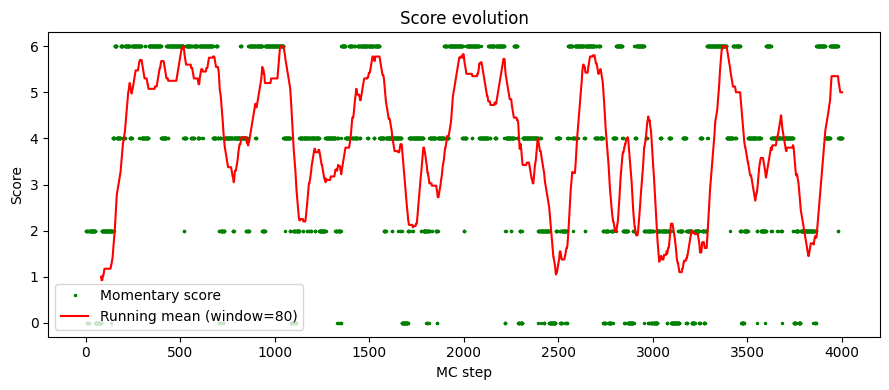

In [17]:

plt.figure(figsize=(9,4))
plt.plot(scores, '.g', ms=3, label='Momentary score')
window = max(10, len(scores)//50)
cumsum = np.cumsum(np.insert(scores, 0, 0.0))
running = (cumsum[window:] - cumsum[:-window]) / window
plt.plot(np.arange(window, len(scores)+1), running, 'r-', lw=1.5, label=f'Running mean (window={window})')
plt.xlabel("MC step")
plt.ylabel("Score")
plt.title("Score evolution")
plt.legend()
plt.tight_layout()
plt.show()



**Question.** Why does the momentary score fluctuate, and why is the running mean smoother? What does a plateau in the running mean indicate?

<details>
<summary>Answer (detailed)</summary>

- **Fluctuations** arise from stochastic MC proposals and probabilistic acceptance. Even with Metropolis, some moves that reduce score are accepted, which helps the chain escape local optima.  
- The **running mean** smooths high-frequency noise by averaging, revealing the underlying trend (improving, plateauing, or drifting).
- A **plateau** suggests the simulation is spending extended time in a metastable basin (local optimum). Without further changes (more steps, different perts, altered acceptance, or a different sequence), additional improvements may be rare.
</details>



## Part 8 — Sequence Design Challenge

Task: Design a 20–30 residue sequence that folds into a compact state with a high score. Try obvious patterns (e.g., blocks of H’s) and compare to alternating sequences.

Suggestions to try (copy into the sequence cell and rerun):
- Compact-promoting: `HHHHHWWWWHHHHHWWWWHHHH`
- Alternating: `HWHWHWHWHWHWHWHWHWHW`
- Mixed blocks: `HHHWHHWWWHHHWHHWWWHHH`

Explain what you observe in terms of the number and geometry of non-consecutive H–H contacts formed.



<details>
<summary>Answer (detailed)</summary>

- **Blocky sequences** with contiguous H segments make it easier to form compact hydrophobic cores, increasing the number of non-consecutive H–H contacts and thus the score.  
- **Perfectly alternating sequences** tend to frustrate compact packing because H’s are separated by W’s along the chain; many potential H–H contacts are backbone-neighbor pairs that do not contribute. Scores typically remain lower, and conformations remain more extended.  
- **Mixed-block sequences** can offer a compromise: enough H clustering to allow hydrophobic core formation while retaining some flexibility in loop closure.
</details>



## Part 9 — Acceptance Criterion: With vs. Without Metropolis

Run the same sequence twice: once with `use_metropolis=True`, once with `use_metropolis=False`. Compare the final best scores and the qualitative dynamics.


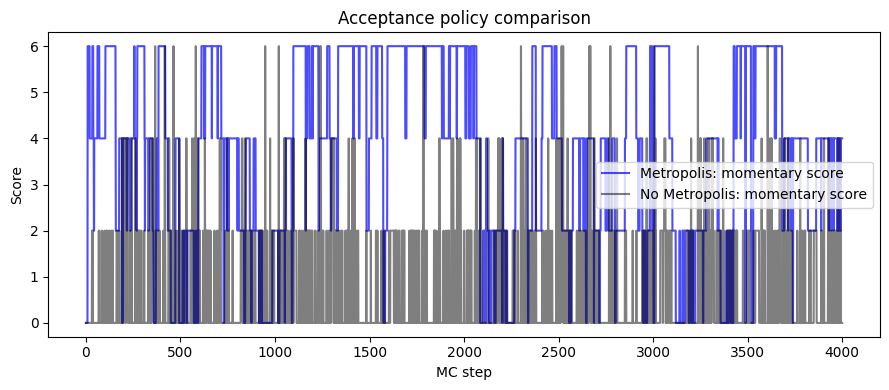

Best score (Metropolis):   6.0
Best score (No Metropolis): 6.0


In [18]:

# Comparison run (reuses global 'sequence', 'steps', 'perts', 'score_weight')
chains_M, scores_M, bestChain_M, bestScore_M = run_simulation(
    sequence, steps=steps, perts=perts, score_weight=score_weight, use_metropolis=True, rng=np.random.default_rng(123)
)

chains_X, scores_X, bestChain_X, bestScore_X = run_simulation(
    sequence, steps=steps, perts=perts, score_weight=score_weight, use_metropolis=False, rng=np.random.default_rng(123)
)

plt.figure(figsize=(9,4))
plt.plot(scores_M, 'b-', alpha=0.7, label='Metropolis: momentary score')
plt.plot(scores_X, 'k-', alpha=0.5, label='No Metropolis: momentary score')
plt.xlabel("MC step")
plt.ylabel("Score")
plt.title("Acceptance policy comparison")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best score (Metropolis):   {bestScore_M:.1f}")
print(f"Best score (No Metropolis): {bestScore_X:.1f}")



<details>
<summary>Answer (detailed)</summary>

- **With Metropolis** the simulation has a bias toward higher scores, stabilizing good conformations while still allowing occasional downhill moves to escape traps. This is analogous to running at a moderate temperature.  
- **Without Metropolis** the simulation indiscriminately accepts proposed states, akin to an extremely high temperature. This increases exploration but often prevents stable residence in high-scoring conformations. Best scores may or may not improve, but trajectories are typically more erratic.
</details>



## Part 10 — Interpreting the Score as an Enthalpy Proxy

Although the **score** is unitless, it acts like a simplified enthalpy: more favorable contacts → lower effective energy (higher score in our convention). Realistic models would include:
- Residue-specific interaction matrices.
- Steric and angular constraints beyond a square lattice.
- Solvent effects and temperature in physical units.

Nevertheless, this exercise captures essential landscape ideas: multiple basins, barriers, and the role of sampling strategy.



## Part 11 — Reflection Questions

1. What sequence features promote the formation of non-consecutive H–H contacts?  
2. How does the perturbation frequency (`perts`) affect convergence and exploration?  
3. If you wished to approximate temperature more explicitly, how could you modify the Metropolis acceptance rule?  
4. In what ways would a continuous-space model (e.g., molecular dynamics with Lennard–Jones potentials) change the conclusions?

<details>
<summary>Answers (detailed)</summary>

1. **Clustered hydrophobic segments** make compact cores feasible; alternating H/W frustrates contacts.  
2. Larger `perts` increases move amplitude per step, potentially improving exploration but also risking frequent rejections (if Metropolis) or excessive thrashing (if not). There is an optimal range that balances local refinement and global moves.  
3. Replace the acceptance probability with \(P = \min\{1, \exp[-\Delta E/(k_B T)]\}\) and identify the score as proportional to negative energy (or negate scores and treat them as energies). Then temperature \(T\) becomes a tunable parameter.  
4. Continuous-space models introduce richer geometries, realistic energetics, and timescales. They often show similar qualitative phenomena (collapse, metastability) but with additional complexities such as side-chain packing, hydrogen bonds, electrostatics, and entropic costs associated with confinement and ordering.
</details>
